In [46]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.v2 as T
import tqdm
import wandb
import cv2
import skdim
import torchvision
import sklearn


sys.path.insert(0, os.path.abspath("python_packages"))
from python_packages import *
from src import *

In [47]:
api = wandb.Api()
model_weights_task1 = api.artifact('hzavadil98/Synthetic data/model-9yhtkfk4:v0', type='model')
model_weights_task2 = api.artifact('hzavadil98/Synthetic data/model-szm46s3x:v0', type='model')
model_weights_task1.download()
model_weights_task2.download()

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


'/Users/jazav7774/UiT/FYS-8603/artifacts/model-szm46s3x:v0'

In [48]:
model_1 = TwoViewCNN.load_from_checkpoint('artifacts/model-j1hmfrrb:v0/model.ckpt')
model_2 = TwoViewCNN.load_from_checkpoint('artifacts/model-rbesenka:v0/model.ckpt')
train_transform = T.Compose(
   [
       T.RandomHorizontalFlip(0.5),
       T.RandomVerticalFlip(0.5),
       T.GaussianNoise(0.1, 0.1),
   ]
)
train_transform = None
dataloader = Synthetic_2v_Dataloader(
   n_samples=[3000, 1000, 1000], train_transform=None, transform=None, batch_size=32, image_save_dir="/Users/jazav7774/Data/Mammo/synthetic"
)

In [49]:
def get_dataset_processed(model, dataloader):
    model.to('mps')
    model.eval()
    all_in_features = []
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="Featurizing dataset"):
            x, y1, y2 = batch
            y = y1 if model.task == 1 else y2
            x = [item.to('mps') for item in x]
            in_features = [resnext(x_i) for resnext, x_i in zip(model.resnexts, x)]
            all_in_features.append(in_features)
            all_logits.append(model.fc(torch.cat(in_features, dim=1)))
            all_labels.append(y)
        all_in_features = [torch.cat([f[i] for f in all_in_features]).cpu().numpy() for i in range(2)]
        all_logits = torch.cat(all_logits, dim=0).cpu().numpy()
        all_labels = torch.cat(all_labels, dim=0).cpu().numpy()
    return all_in_features, all_logits, all_labels

#task1_train_features, task1_train_logits, task1_train_labels = get_dataset_processed(model_1, dataloader.train_dataloader(shuffle=False))
#task1_val_features, task1_val_logits, task1_val_labels = get_dataset_processed(model_1, dataloader.val_dataloader())
task1_test_features, task1_test_logits, task1_test_labels = get_dataset_processed(model_1, dataloader.test_dataloader())
#task2_train_features, task2_train_logits, task2_train_labels = get_dataset_processed(model_2, dataloader.train_dataloader(shuffle=False))
#task2_val_features, task2_val_logits, task2_val_labels = get_dataset_processed(model_2, dataloader.val_dataloader())
task2_test_features, task2_test_logits, task2_test_labels = get_dataset_processed(model_2, dataloader.test_dataloader())

Featurizing dataset: 100%|██████████| 32/32 [00:53<00:00,  1.69s/it]


In [50]:
test_sorted_indices = np.argsort(task1_test_labels)
task1_test_features = [f[test_sorted_indices] for f in task1_test_features]
task1_test_logits = task1_test_logits[test_sorted_indices]
task1_test_labels = task1_test_labels[test_sorted_indices]
test_sorted_indices = np.argsort(task2_test_labels)
task2_test_features = [f[test_sorted_indices] for f in task2_test_features]
task2_test_logits = task2_test_logits[test_sorted_indices]
task2_test_labels = task2_test_labels[test_sorted_indices]

# saliency maps


In [51]:
sum(np.argmax(task1_test_logits, axis=1)== task1_test_labels)

np.int64(820)

In [52]:
def saliency_map(model, x, plot=True):
    """
    Computes the saliency map of an input sample with respect to the predicted class. 
    
    Parameters:
        model (torch.nn.Module): Trained model.
        x (list): List of input samples from Breast_Cancer_Dataloader.
        plot (bool): Whether to plot the saliency map. 
        
    Returns:
        saliency (list): List of saliency maps.
        target_class (int): Predict
    """
    x = [item.to('mps') for item in x]
    model.to('mps')
    for i in range(2):
        x[i] = x[i].unsqueeze(0)
        x[i].requires_grad = True

    output = model(x)
    target_class = output.argmax(dim=1)

    model.zero_grad()
    output[0, target_class].backward()
    saliency = [sample.grad.abs().max(dim=1)[0].squeeze().cpu().numpy() for sample in x]
    
    if plot:
        fig, axs = plt.subplots(2, 2)
        for i in range(2):
            axs[0, i].imshow(x[i].cpu().detach().numpy()[0,0,:,:], cmap='gray')
            axs[0, i].set_title(f'view: {'CC' if i == 0 else 'MLO'}')
            axs[0, i].axis('off')
            axs[1, i].imshow(saliency[i], cmap='hot')
            axs[1, i].set_title(f"y=: , y_hat: {target_class.item()}")
            axs[1, i].axis('off')

    
    return saliency, target_class.item()

def overlay_saliency_on_image(image, saliency, alpha=0.5, colormap=cv2.COLORMAP_JET, plot=True):
    """
    Overlays a saliency map on an image.
    
    Parameters:
        image (np.ndarray/torch.Tensor): Image.
        saliency (np.ndarray/torch.Tensor): Saliency map.
        alpha (float): Transparency of the heatmap (0 = only image, 1 = only heatmap).
        colormap (int): OpenCV colormap (e.g., cv2.COLORMAP_JET).
        plot (bool): Whether to plot the overlayed image.
        
    Returns:
        image (np.ndarray): Original image.
        overlayed_img (np.ndarray): Overlayed image.
    """

    if isinstance(saliency, torch.Tensor):
        saliency = saliency.cpu().detach().numpy()  # Convert PyTorch tensor to NumPy
    if isinstance(image, torch.Tensor):
        image = image.cpu().detach().numpy()  # Convert PyTorch tensor to NumPy
    elif isinstance(image, torchvision.tv_tensors._image.Image):
        image = np.array(image)  # Convert torchvision Image to NumPy

    # Normalize saliency map to range [0, 255]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())  # Normalize to [0,1]
    saliency = (saliency * 255).astype(np.uint8)  # Scale to [0,255]

    heatmap = saliency
    # Apply a colormap to make the saliency map visually interpretable
    heatmap = cv2.applyColorMap(saliency, colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)  # Convert OpenCV BGR to grayscale

    # Convert grayscale image to 3-channel for blending
    if len(image.shape) == 3:  
        image = image[0]
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0,1]
    image = (image * 255).astype(np.uint8)
       
    # Blend the heatmap with the original image
    overlayed_img = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

    if plot:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title('Image')
        plt.subplot(1, 2, 2)
        plt.imshow(overlayed_img, cmap='jet')
        plt.axis('off')
        plt.title('Overlayed Image')
        plt.show()  
    
    return image, overlayed_img

def overlay_saliency_on_pair(model, dataloader, split, idx, alpha=0.5, colormap=cv2.COLORMAP_JET, plot=True):
    """
    Overlays saliency maps on a pair of images from a dataloader.
    
    Parameters:
        model (torch.nn.Module): Trained model.
        dataloader (Breast_Cancer_Dataloader): Breast cancer dataloader.
        split (str): Dataset split ('train', 'val', 'test').
        idx (int): Index of the image pair.
        alpha (float): Transparency of the heatmap (0 = only image, 1 = only heatmap).
        colormap (int): OpenCV colormap (e.g., cv2.COLORMAP_JET).
        plot (bool): Whether to plot the overlayed images.
        
    Returns:
        images (list): List of original images.
        saliencies (list): List of saliency maps.
        overlayed_imgs (list): List of overlayed images.    
    """
    if split == 'train':
        images, y1, y2 = dataloader.train_dataset[idx]
    elif split =='val':
        images, y1, y2 = dataloader.val_dataset[idx]
    elif split == 'test':
        images, y1, y2 = dataloader.test_dataset[idx]
    y = y1 if model.task == 1 else y2
    
    saliencies, y_hat = saliency_map(model, images, plot=False)
    
    results = []
    for image, saliency in zip(images, saliencies):
        results.append(overlay_saliency_on_image(image, saliency, alpha, colormap, plot=False))
    images, overlayed_imgs = zip(*results)
    # plot both overlayed saliency maps next to the original images
    if plot:
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        for i in range(2):
            axs[0, i].imshow(images[i], cmap='gray')
            axs[0, i].set_title(f'view: {'1' if i == 0 else '2'}. y=: {y}, y_hat: {y_hat}')
            axs[0, i].axis('off')
            axs[1, i].imshow(saliencies[i], cmap='hot')
            axs[1, i].set_title('pure saliency map')
            axs[1, i].axis('off')
            #axs[2, i].imshow(overlayed_imgs[i], cmap='jet')
            #axs[2, i].set_title(f"y=: {y}, y_hat: {y_hat}")
            #axs[2, i].axis('off')
    return images, saliencies, overlayed_imgs
    

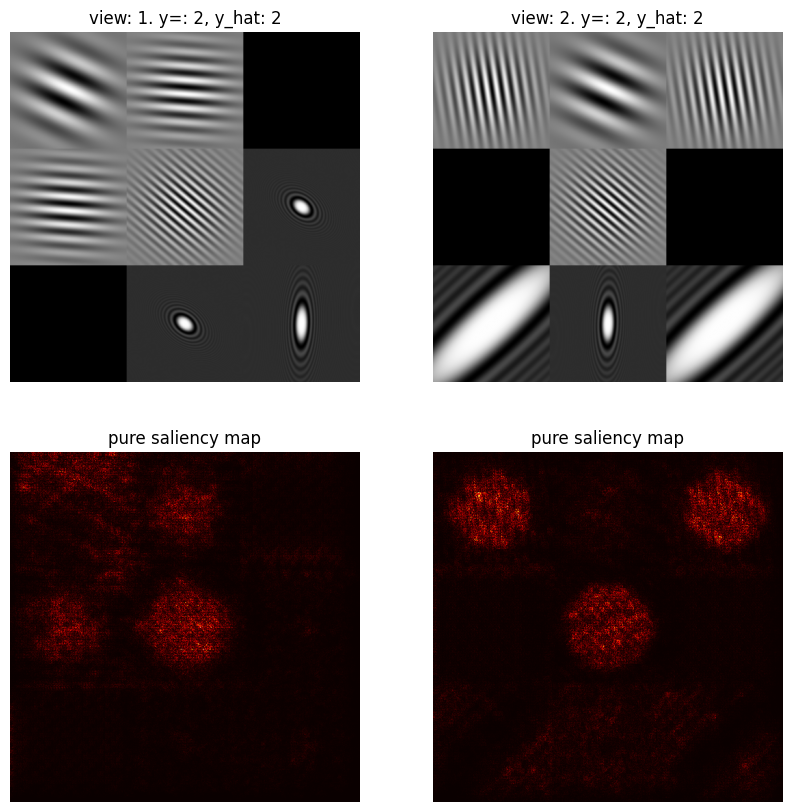

In [53]:
images, saliencies, overlayed_imgs = overlay_saliency_on_pair(model_1, dataloader, 'test', 20, alpha=0.5, colormap=cv2.COLORMAP_JET)

# Two data blocks

In [54]:
task1_test_features[0].shape

(1000, 512)

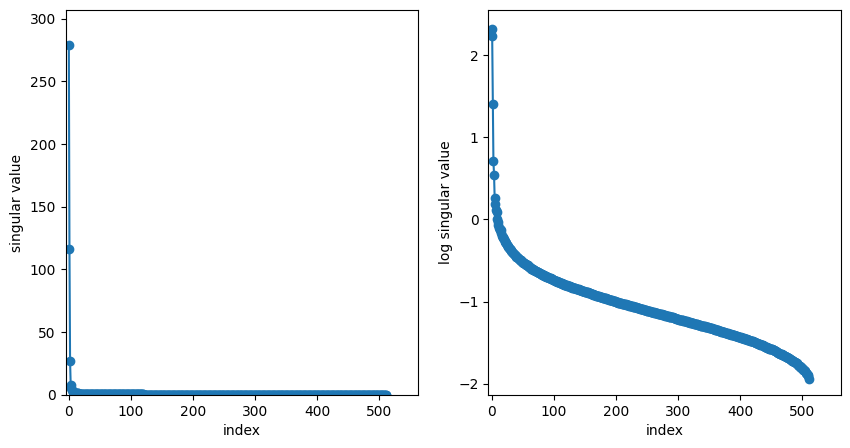

In [55]:
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
PCA().fit(task1_test_features[0]).plot_scree(log = False)
plt.subplot(1, 2, 2)
PCA().fit(task1_test_features[1]).plot_scree(log = True)

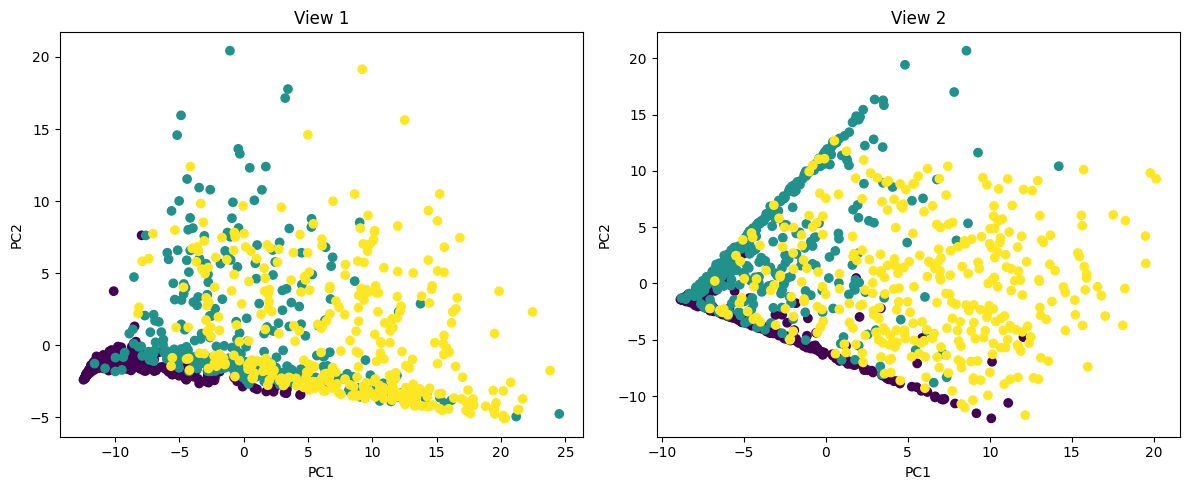

In [56]:


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i in range(2):
    pca = sklearn.decomposition.PCA(n_components=2)
    X_pca = pca.fit_transform(task1_test_features[i])
    scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=task1_test_labels)
    axes[i].set_title(f'View {i+1}')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
plt.tight_layout()
plt.show()

In [57]:
ajive = AJIVE(init_signal_ranks=[20,20])
ajive.fit(task1_test_features)
#ajive.plot_joint_diagnostic()
ajive.summary()

'AJIVE, joint rank: 2, view 0 indiv rank: 18, view 1 indiv rank: 18'

# Ajive task1 vs task2


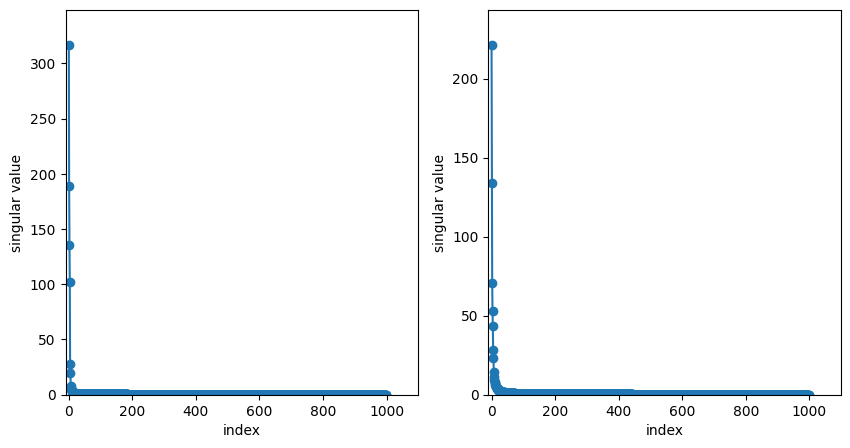

In [58]:
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
PCA().fit(np.concatenate(task1_test_features, axis=1)).plot_scree(log = False)
plt.subplot(1, 2, 2)
PCA().fit(np.concatenate(task2_test_features, axis=1)).plot_scree(log = False)

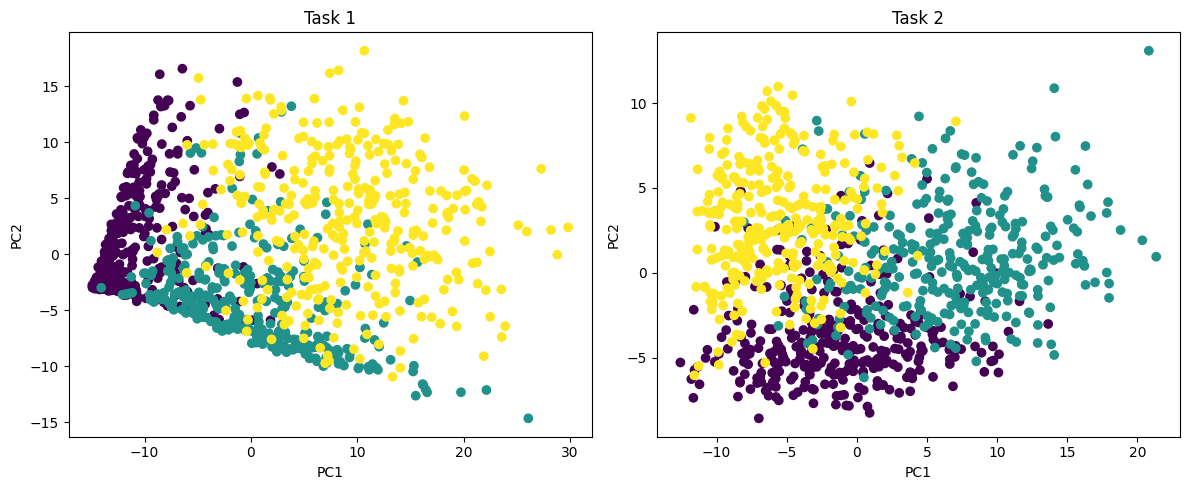

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, (dat, labels) in enumerate([
    (task1_test_features, task1_test_labels),
    (task2_test_features, task2_test_labels)
]):
    pca = sklearn.decomposition.PCA(n_components=2)
    X_pca = pca.fit_transform(np.concatenate(dat, axis=1))
    scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
    axes[i].set_title(f'Task {i+1}')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
plt.tight_layout()
plt.show()

In [60]:
ajive = AJIVE(init_signal_ranks=[50,50])
ajive.fit([np.concatenate(task1_test_features, axis=1), np.concatenate(task2_test_features, axis=1)])
#ajive.plot_joint_diagnostic()
ajive.summary()

'AJIVE, joint rank: 1, view 0 indiv rank: 50, view 1 indiv rank: 50'

In [61]:
ajive.common_.views_[0].view_loadings_.shape

(1024, 1)

In [62]:
#transformed = np.concatenate(task1_test_features, axis=1) @ ajive.common_.views_[0].view_loadings_
loadings = ajive.common_.views_[0].view_loadings_
evals = np.diag(ajive.common_.evals_)
scores = ajive.common_.views_[0].view_scores_
np.mean(np.abs((loadings @ evals @ scores.T).T-np.concatenate(task1_test_features, axis=1)))

np.float32(0.51235217)

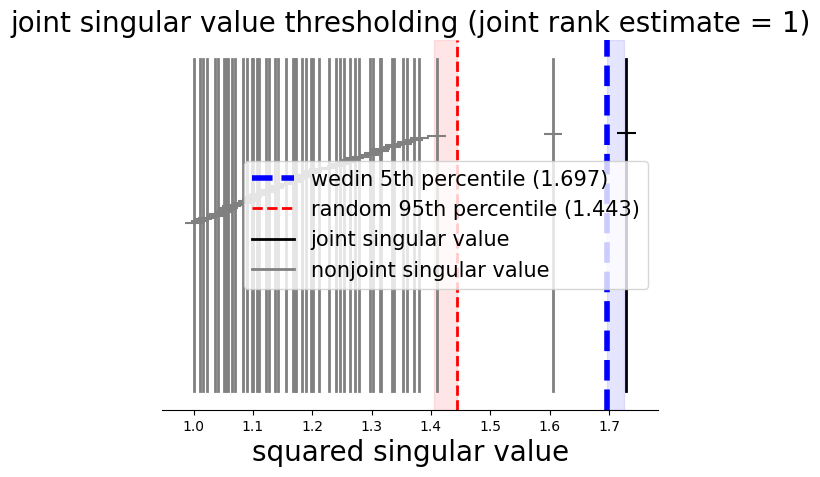

In [63]:
ajive.plot_joint_diagnostic()

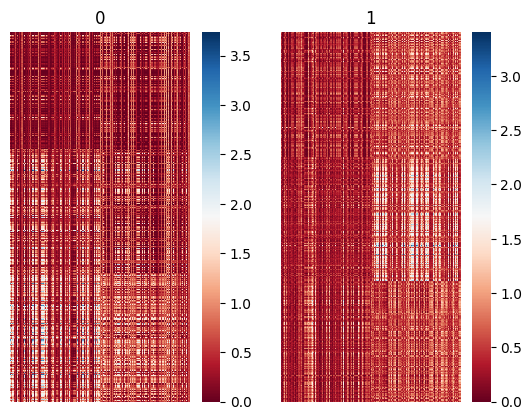

In [64]:
data_block_heatmaps([np.concatenate(task1_test_features, axis=1), np.concatenate(task2_test_features, axis=1)])

Using model: model_1 (Task 1)
Shape of first common loading vector: (1024,)
Input images_for_saliency shapes: [torch.Size([1, 512, 512]), torch.Size([1, 512, 512])]


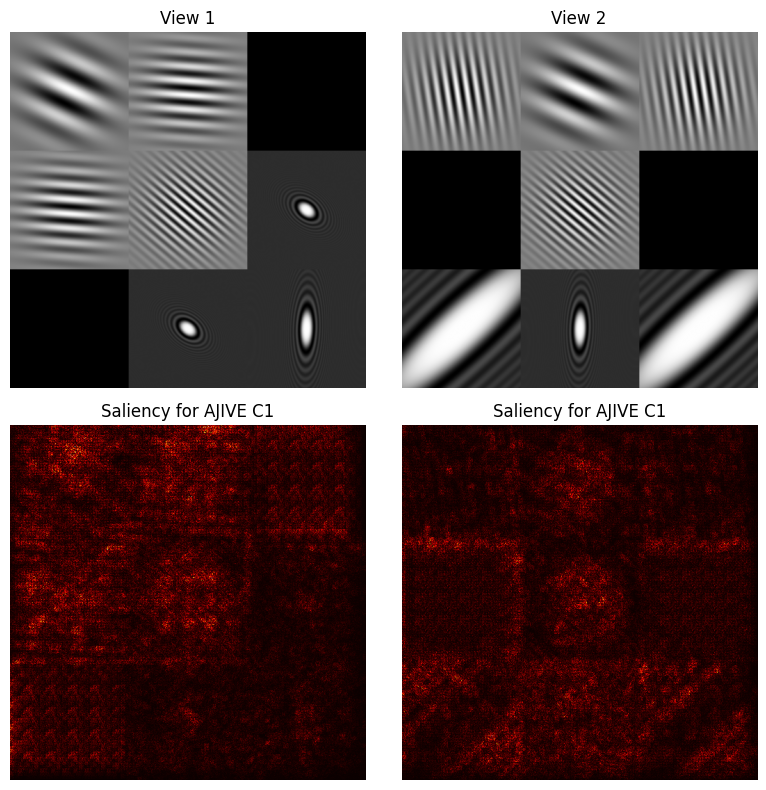

Generated saliency maps shapes: [(512, 512), (512, 512)]


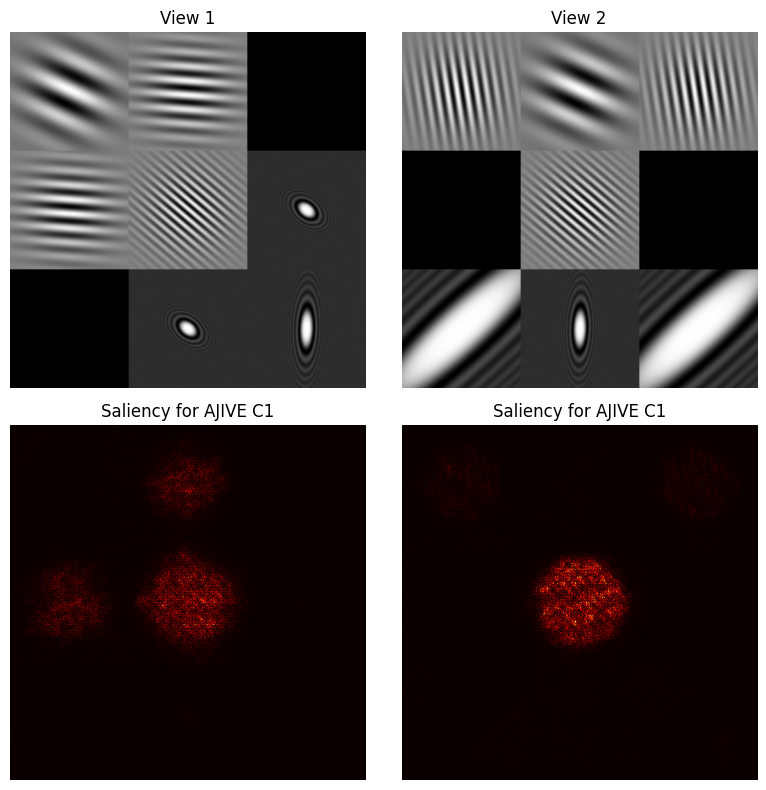

: 

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2 # For colormap if needed

def ajive_saliency_map(model, x_list, common_loading_vector, plot=True):
    """
    Computes the saliency map of an input sample with respect to a given AJIVE common loading vector.
    
    Parameters:
        model (torch.nn.Module): Trained model.
        x_list (list): List of input image tensors (e.g., [(C,H,W), (C,H,W)]) for each view.
                       Each tensor should be for a single sample, without the batch dimension.
        common_loading_vector (np.ndarray): The AJIVE common loading vector (e.g., for concatenated features).
        plot (bool): Whether to plot the saliency map. 
        
    Returns:
        saliency_maps (list): List of saliency maps (np.ndarray) for each view.
    """
    device = next(model.parameters()).device
    model.eval() # Ensure model is in evaluation mode

    x_processed_with_grad = []
    original_images_for_plot = []

    for x_item in x_list:
        # Ensure x_item is on the correct device and has the right shape (1, C, H, W)
        # x_item is expected to be (C,H,W) or (1,H,W) if channel is 1
        img = x_item.clone().detach().to(device)
        original_images_for_plot.append(img.cpu()) # Store for plotting before adding batch dim

        if img.ndim == 2: # (H, W) -> (1, 1, H, W)
            img = img.unsqueeze(0).unsqueeze(0)
        elif img.ndim == 3: # (C, H, W) -> (1, C, H, W)
            img = img.unsqueeze(0)
        elif img.ndim == 4 and img.shape[0] == 1: # Already (1, C, H, W)
            pass
        else:
            raise ValueError(f"Input image tensor has unexpected shape: {x_item.shape}")
        
        img.requires_grad = True
        x_processed_with_grad.append(img)

    # Get intermediate features (output of model.resnexts for each view)
    # These should be [1, 512] for each view after passing through resnexts
    features_v1 = model.resnexts[0](x_processed_with_grad[0])
    features_v2 = model.resnexts[1](x_processed_with_grad[1])

    # Ensure loading vector is a tensor on the correct device
    loading_vector_tensor = torch.tensor(common_loading_vector, dtype=features_v1.dtype, device=device)
    if loading_vector_tensor.ndim == 1:
        loading_vector_tensor = loading_vector_tensor.unsqueeze(0) # Make it [1, D] if it's [D] for matmul

    expected_feature_dim = features_v1.shape[1] + features_v2.shape[1]
    if loading_vector_tensor.shape[1] != expected_feature_dim: # common_loading_vector is [D], so loading_vector_tensor is [1,D]
        raise ValueError(
            f"Dimension mismatch: loading vector has dimension {loading_vector_tensor.shape[1]}, "
            f"but concatenated features have dimension {expected_feature_dim}."
        )

    concatenated_features = torch.cat((features_v1, features_v2), dim=1)  # Shape: [1, 1024]
    
    # ajive_score = torch.matmul(concatenated_features, loading_vector_tensor.t()) # if loading_vector_tensor is [1,D] -> [1,1]
    ajive_score = torch.sum(concatenated_features * loading_vector_tensor) # Element-wise product and sum for [1,D] and [1,D] -> scalar

    if ajive_score.numel() != 1:
        raise ValueError(f"AJIVE score must be a scalar. Got shape: {ajive_score.shape}")
    
    scalar_ajive_score = ajive_score # It's already scalar after sum

    model.zero_grad()
    # Ensure grads of inputs are zero if they exist from previous ops
    for x_p in x_processed_with_grad:
        if x_p.grad is not None:
            x_p.grad.detach_()
            x_p.grad.zero_()
            
    scalar_ajive_score.backward()

    saliency_maps_list = []
    for x_item_processed in x_processed_with_grad:
        if x_item_processed.grad is None:
            print(f"Warning: Gradient for an input item is None. Returning zero saliency map for this item.")
            h, w = x_item_processed.shape[2], x_item_processed.shape[3] # (1, C, H, W)
            saliency_map_np = np.zeros((h, w), dtype=np.float32)
        else:
            # Grad shape is (1, C, H, W). Max over C -> (1, H, W). Squeeze -> (H, W)
            saliency_map_tensor = x_item_processed.grad.abs().max(dim=1)[0] 
            saliency_map_np = saliency_map_tensor.squeeze().cpu().numpy()
        saliency_maps_list.append(saliency_map_np)
    
    if plot:
        fig, axs = plt.subplots(2, len(x_list), figsize=(4 * len(x_list), 8))
        if len(x_list) == 1: # Ensure axs is 2D array for consistent indexing
            axs = np.array([axs]).T 


        for i in range(len(x_list)):
            # original_images_for_plot[i] is (C,H,W) or (1,H,W)
            img_to_show = original_images_for_plot[i].squeeze().numpy() # Squeeze out channel if 1
            if img_to_show.ndim == 3 and img_to_show.shape[0] > 1 : # (C,H,W) with C > 1
                img_to_show = img_to_show[0] # Show first channel if multi-channel (e.g. RGB)

            axs[0, i].imshow(img_to_show, cmap='gray')
            axs[0, i].set_title(f'View {i+1}')
            axs[0, i].axis('off')
            
            axs[1, i].imshow(saliency_maps_list[i], cmap='hot')
            axs[1, i].set_title(f"Saliency for AJIVE C1")
            axs[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return saliency_maps_list

# --- Script to use the function ---
# Ensure 'ajive', 'model_1', and 'dataloader' are available from previous cells.
# ajive from cell '9fbbf20c'
# model_1 from cell '0d9eec78'
# dataloader from cell '0d9eec78'

# The ajive object was fit on [np.concatenate(task1_test_features, axis=1), np.concatenate(task2_test_features, axis=1)]
# common_.views_[0] corresponds to the first block: np.concatenate(task1_test_features, axis=1)
# These features were generated by model_1.
try:
    first_common_loading = ajive.common_.views_[0].view_loadings_[:,0]
    first_indiv_loading = ajive.view_specific_[0].individual_.loadings_[:,0]

    # Get a sample from the test dataset (e.g., the 7th sample as used in cell '829e1c9a')
    sample_idx = 20
    images_for_saliency, y1_label, y2_label = dataloader.test_dataset[sample_idx] 
    # images_for_saliency is a list of tensors, e.g. [view1_tensor, view2_tensor]
    # Each tensor is expected to be (C, H, W)

    # Ensure model_1 is on the correct device (it should be from previous cells)
    # model_1.to('mps') # Or whatever device was used. Assume it's already set.

    print(f"Using model: model_1 (Task {model_1.task if hasattr(model_1, 'task') else 'N/A'})")
    print(f"Shape of first common loading vector: {first_common_loading.shape}")
    print(f"Input images_for_saliency shapes: {[img.shape for img in images_for_saliency]}")

    # Generate and plot AJIVE saliency map
    ajive_saliency_maps_result = ajive_saliency_map(model_1, images_for_saliency, first_common_loading, plot=True)
    print(f"Generated saliency maps shapes: {[s_map.shape for s_map in ajive_saliency_maps_result]}")

    ajive_saliency_map(model_1, images_for_saliency, first_indiv_loading, plot=True)

except NameError as e:
    print(f"Error: A required variable (ajive, model_1, or dataloader) is not defined. Please ensure previous cells have been run. Details: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    
    

